<a href="https://colab.research.google.com/github/peterbabulik/QuantumWalker/blob/main/QuantumRule30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cirq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.5/597.5 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.1/425.1 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 70.2 MB/s eta 0:00:00


Using Rule 30 Static Pattern (first 20 elements): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1]
Starting 1D Quantum Walk with Rule 30 dependent coin...
Initialized 1D walker at site 25 in coin state |0> (index 50)

Starting 1D QW (Rule 30 Coin) for 50 steps...
  Completed step 10/50
  Completed step 20/50
  Completed step 30/50
  Completed step 40/50
  Completed step 50/50
Evolution complete. Time: 0.02 seconds.

--- 1D QW (Rule 30 Coin) Summary ---
N_sites=51, Depth=50, StartPos=25, StartCoin=0

Top 5 Final Probabilities (Site: Prob):
  Site 25: 0.41159
  Site 31: 0.21580
  Site 27: 0.17751
  Site 29: 0.05125
  Site 15: 0.02965

Coin-Position Entanglement vs. Time:
  Step 0: S = 0.000000
  Step 25: S = 0.983846
  Step 50: S = 0.858381
--- End of Summary ---


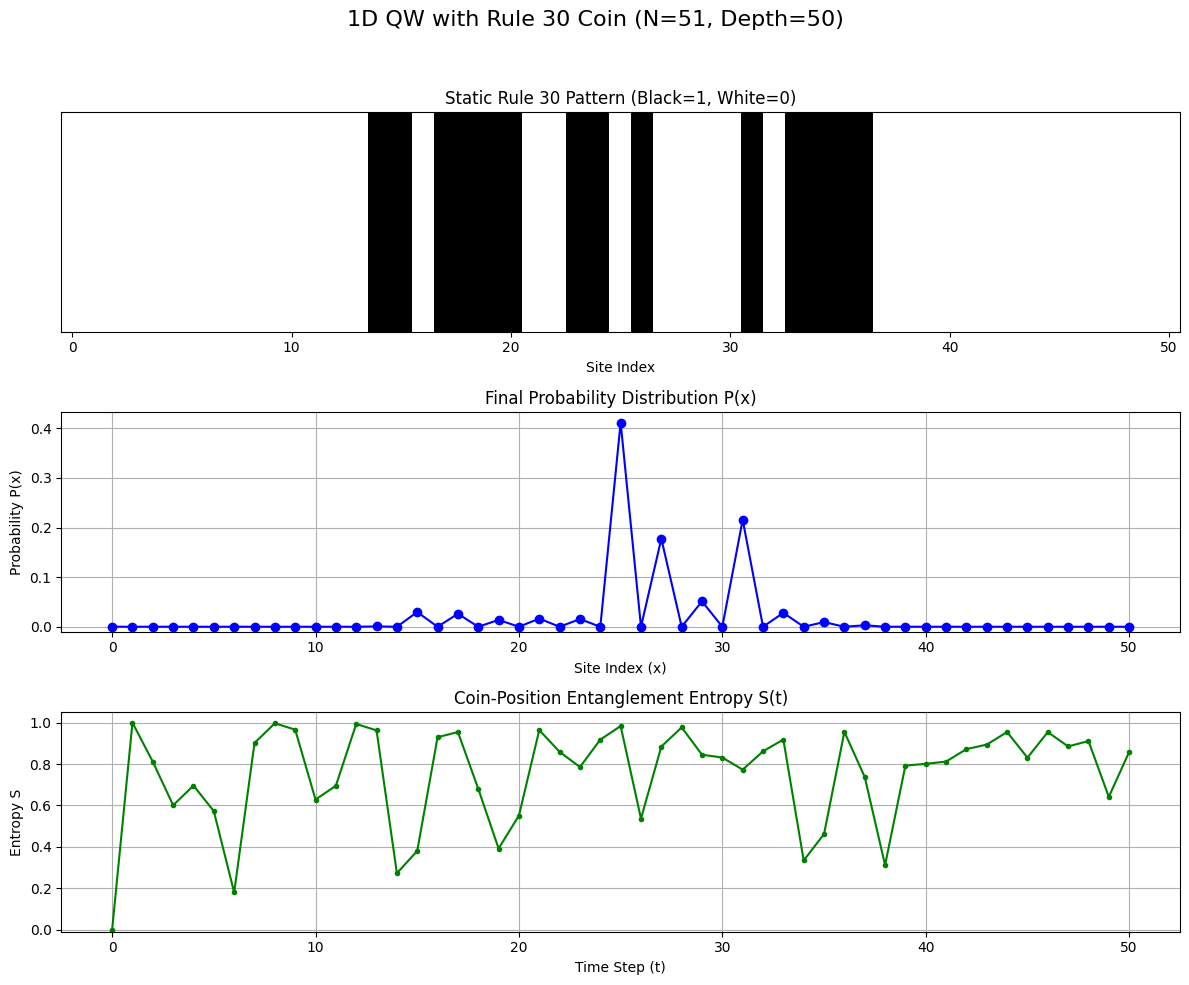


<<<<< END OF 1D QW RULE 30 SIMULATION >>>>>


In [4]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import time

# --- Parameters ---
N_SITES_1D = 51       # Number of sites (odd for center start)
DEPTH_1D = 50         # Number of QW steps
INITIAL_POS_1D = N_SITES_1D // 2
INITIAL_COIN_1D = 0 # Start with coin state |0>

# --- Rule 30 Pattern Generation ---
def generate_rule30_pattern(width, steps, initial_center_one=True):
    line = np.zeros(width, dtype=int)
    if initial_center_one and width > 0 and width % 2 == 1: # Ensure center exists for odd width
        line[width // 2] = 1
    elif initial_center_one and width > 0: # For even width, pick one near center
        line[width // 2 -1] = 1

    history = [line.copy()]
    for _ in range(steps - 1): # Evolve for 'steps-1' more iterations
        new_line = np.zeros(width, dtype=int)
        for i in range(width):
            left = line[(i - 1 + width) % width]
            center = line[i]
            right = line[(i + 1) % width]

            pattern_val = (left << 2) | (center << 1) | right # LCR as 3 bits
            # Rule 30 output: (pattern_val XOR ( (pattern_val >> 1) | (pattern_val >> 2) ) ) & 1
            # A simpler way for Rule 30 binary representation:
            # L C R -> Next C
            # 1 1 1 -> 0
            # 1 1 0 -> 0
            # 1 0 1 -> 0
            # 1 0 0 -> 1
            # 0 1 1 -> 1
            # 0 1 0 -> 1
            # 0 0 1 -> 1
            # 0 0 0 -> 0
            if pattern_val in [1, 2, 3, 4]: # Decimal for 001, 010, 011, 100
                new_line[i] = 1
            else:
                new_line[i] = 0
        line = new_line
        history.append(line.copy())
    return history[-1] # Return the final pattern after 'steps' evolutions

# Generate a static Rule 30 pattern (e.g., evolved for N_SITES_1D // 4 steps)
R30_STATIC_PATTERN = generate_rule30_pattern(N_SITES_1D, N_SITES_1D // 4)
print(f"Using Rule 30 Static Pattern (first 20 elements): {R30_STATIC_PATTERN[:20]}")


# --- Coin Matrices (1-Qubit Coin) ---
H_1Q = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]], dtype=np.complex128)
X_1Q = np.array([[0,1],[1,0]], dtype=np.complex128)
I_1Q = np.eye(2, dtype=np.complex128)

COIN_OP_R30_ZERO = H_1Q         # Coin to apply if R30_pattern[site] == 0
COIN_OP_R30_ONE  = X_1Q @ H_1Q  # Coin to apply if R30_pattern[site] == 1 (example)
# COIN_OP_R30_ONE  = X_1Q  # Simpler alternative for COIN_TYPE_1

# --- Helper Functions (1D QW) ---
# State vector index: k = coin_val + 2 * site_pos (coin_val = 0 or 1)
def get_1d_index(coin_val, site_pos, n_sites_1d):
    if not (0 <= site_pos < n_sites_1d and 0 <= coin_val <= 1):
        raise IndexError(f"Invalid coin ({coin_val}) or pos ({site_pos}) for 1D index (N_sites={n_sites_1d})")
    return coin_val + 2 * site_pos

def get_1d_coin_pos_from_index(k, n_sites_1d):
    state_dim_1d = 2 * n_sites_1d
    if not (0 <= k < state_dim_1d):
        raise IndexError(f"Invalid k ({k}) for 1D coin/pos (StateDim={state_dim_1d})")
    coin_val = k % 2
    site_pos = k // 2
    return coin_val, site_pos

# --- Initial State Preparation (1D QW) ---
def prepare_initial_state_1d(n_sites_1d, initial_pos, initial_coin_val=0):
    state_dim_1d = 2 * n_sites_1d
    initial_state_vector = np.zeros(state_dim_1d, dtype=np.complex128)
    try:
        start_index = get_1d_index(initial_coin_val, initial_pos, n_sites_1d)
        initial_state_vector[start_index] = 1.0
        print(f"Initialized 1D walker at site {initial_pos} in coin state |{initial_coin_val}> (index {start_index})")
    except IndexError as e:
        print(f"Error during 1D initial state prep: {e}")
        # initial_state_vector.fill(0) # Or handle error differently
    return initial_state_vector

# --- Build Operators (1D QW with Rule-30 Coin) ---
def build_1d_qw_operators_rule30_coin(n_sites_1d, r30_pattern, coin0_op, coin1_op):
    state_dim_1d = 2 * n_sites_1d

    # Coin Operator C_full
    C_full = np.zeros((state_dim_1d, state_dim_1d), dtype=np.complex128)
    for site_idx in range(n_sites_1d):
        chosen_coin_op = coin0_op if r30_pattern[site_idx] == 0 else coin1_op

        idx_s_c0 = get_1d_index(0, site_idx, n_sites_1d)
        idx_s_c1 = get_1d_index(1, site_idx, n_sites_1d)

        C_full[idx_s_c0, idx_s_c0] = chosen_coin_op[0,0]
        C_full[idx_s_c1, idx_s_c0] = chosen_coin_op[1,0]
        C_full[idx_s_c0, idx_s_c1] = chosen_coin_op[0,1]
        C_full[idx_s_c1, idx_s_c1] = chosen_coin_op[1,1]

    # Shift Operator S_full (Periodic Boundaries)
    S_full = np.zeros((state_dim_1d, state_dim_1d), dtype=np.complex128)
    for k_in in range(state_dim_1d):
        coin_val, site_pos = get_1d_coin_pos_from_index(k_in, n_sites_1d)
        new_pos = site_pos
        if coin_val == 0: # Coin |0> moves left
            new_pos = (site_pos - 1 + n_sites_1d) % n_sites_1d
        else: # Coin |1> moves right
            new_pos = (site_pos + 1) % n_sites_1d
        k_out = get_1d_index(coin_val, new_pos, n_sites_1d)
        S_full[k_out, k_in] = 1.0

    U_step = S_full @ C_full
    return U_step

# --- Observables (1D QW) ---
def calculate_p1_position_1d(state_vector, n_sites_1d):
    prob_dist_1d = np.zeros(n_sites_1d)
    for site_idx in range(n_sites_1d):
        idx_c0 = get_1d_index(0, site_idx, n_sites_1d)
        idx_c1 = get_1d_index(1, site_idx, n_sites_1d)
        prob_dist_1d[site_idx] = np.abs(state_vector[idx_c0])**2 + np.abs(state_vector[idx_c1])**2
    return prob_dist_1d

def calculate_coin_position_entanglement_1d(state_vector, n_sites_1d):
    coin_dim = 2
    state_dim_1d = coin_dim * n_sites_1d
    if len(state_vector) != state_dim_1d: return np.nan

    norm = np.linalg.norm(state_vector)
    if np.abs(norm - 1.0) > 1e-6:
        if norm < 1e-9: return 0.0
        state_vector = state_vector / norm
        if np.isnan(state_vector).any(): return np.nan
    try:
        rho_full_matrix = np.outer(state_vector, np.conjugate(state_vector))
        rho_coin = np.zeros((coin_dim, coin_dim), dtype=np.complex128)
        for site_idx in range(n_sites_1d):
            for c_row in range(coin_dim):
                 for c_col in range(coin_dim):
                      k_row = get_1d_index(c_row, site_idx, n_sites_1d)
                      k_col = get_1d_index(c_col, site_idx, n_sites_1d)
                      rho_coin[c_row, c_col] += rho_full_matrix[k_row, k_col]
        trace_rho_coin = np.trace(rho_coin)
        if np.abs(trace_rho_coin - 1.0) > 1e-6:
            if abs(trace_rho_coin) > 1e-9: rho_coin /= trace_rho_coin
        eigenvalues = np.linalg.eigvalsh(rho_coin)
        entropy = 0.0; epsilon = 1e-12
        for eig_val in eigenvalues:
            if eig_val > epsilon:
                try: entropy -= eig_val * np.log2(eig_val)
                except ValueError: pass
        return max(0.0, np.real(entropy))
    except Exception as e:
        print(f"Error calculating 1D coin-position entanglement: {e}")
        return np.nan

# --- Simulation Loop (1D QW) ---
def run_1d_qw_simulation_rule30_coin(
    n_sites_1d, depth, initial_pos, initial_coin_val,
    r30_pattern, coin0_op, coin1_op
):
    initial_state = prepare_initial_state_1d(n_sites_1d, initial_pos, initial_coin_val)
    U_step = build_1d_qw_operators_rule30_coin(n_sites_1d, r30_pattern, coin0_op, coin1_op)

    current_state = initial_state.copy()
    prob_history_1d = [calculate_p1_position_1d(current_state, n_sites_1d)]
    ent_history_1d = [calculate_coin_position_entanglement_1d(current_state, n_sites_1d)]

    print(f"\nStarting 1D QW (Rule 30 Coin) for {depth} steps...")
    start_time = time.time()
    for step in range(depth):
        current_state = U_step @ current_state
        norm = np.linalg.norm(current_state) # Normalize at each step
        if abs(norm) > 1e-9 : current_state /= norm
        else: print(f"Warning: State norm zero at step {step+1}"); break

        prob_history_1d.append(calculate_p1_position_1d(current_state, n_sites_1d))
        ent_history_1d.append(calculate_coin_position_entanglement_1d(current_state, n_sites_1d))
        if (step + 1) % 10 == 0:
            print(f"  Completed step {step + 1}/{depth}")
    end_time = time.time()
    print(f"Evolution complete. Time: {end_time - start_time:.2f} seconds.")

    return {
        "prob_history": np.array(prob_history_1d),
        "ent_history": np.array(ent_history_1d),
        "r30_pattern": r30_pattern,
        "params": {
            "n_sites": n_sites_1d, "depth": depth,
            "initial_pos": initial_pos, "initial_coin": initial_coin_val
        }
    }

# --- Plotting and Summary (1D QW) ---
def plot_1d_qw_results_rule30(results):
    params = results["params"]; prob_hist = results["prob_history"]; ent_hist = results["ent_history"]
    r30_pattern = results["r30_pattern"]

    fig, axs = plt.subplots(3, 1, figsize=(12, 10))
    fig.suptitle(f"1D QW with Rule 30 Coin (N={params['n_sites']}, Depth={params['depth']})", fontsize=16)

    # Plot Rule 30 pattern
    axs[0].imshow(r30_pattern[np.newaxis, :], cmap='binary', aspect='auto', interpolation='nearest')
    axs[0].set_title("Static Rule 30 Pattern (Black=1, White=0)")
    axs[0].set_xlabel("Site Index"); axs[0].set_yticks([])

    # Plot final probability distribution
    axs[1].plot(np.arange(params['n_sites']), prob_hist[-1, :], marker='o', linestyle='-', color='blue')
    axs[1].set_title("Final Probability Distribution P(x)")
    axs[1].set_xlabel("Site Index (x)"); axs[1].set_ylabel("Probability P(x)")
    axs[1].grid(True); axs[1].set_ylim(bottom=-0.01)

    # Plot entanglement history
    time_steps = np.arange(params['depth'] + 1)
    axs[2].plot(time_steps, ent_hist, marker='.', linestyle='-', color='green')
    axs[2].set_title("Coin-Position Entanglement Entropy S(t)")
    axs[2].set_xlabel("Time Step (t)"); axs[2].set_ylabel("Entropy S")
    axs[2].grid(True); axs[2].set_ylim(bottom=-0.01, top=1.05) # Max ent for 1 qubit coin = log2(2)=1

    plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

def generate_1d_qw_text_output_rule30(results):
    params = results["params"]; prob_hist = results["prob_history"]; ent_hist = results["ent_history"]
    output_lines = ["\n--- 1D QW (Rule 30 Coin) Summary ---"]
    output_lines.append(f"N_sites={params['n_sites']}, Depth={params['depth']}, StartPos={params['initial_pos']}, StartCoin={params['initial_coin']}")

    output_lines.append("\nTop 5 Final Probabilities (Site: Prob):")
    final_probs = prob_hist[-1, :]
    sorted_indices = np.argsort(final_probs)[::-1]
    for i in range(min(5, params['n_sites'])):
        idx = sorted_indices[i]
        output_lines.append(f"  Site {idx}: {final_probs[idx]:.5f}")

    output_lines.append("\nCoin-Position Entanglement vs. Time:")
    num_steps_total = len(ent_hist)
    indices_to_show = [0]
    if num_steps_total > 2: indices_to_show.append(num_steps_total // 2)
    if num_steps_total > 1: indices_to_show.append(num_steps_total - 1)
    indices_to_show = sorted(list(set(indices_to_show)))
    for idx in indices_to_show:
        s_val_str = f"{ent_hist[idx]:.6f}" if np.isfinite(ent_hist[idx]) else "nan"
        output_lines.append(f"  Step {idx}: S = {s_val_str}")
    output_lines.append("--- End of Summary ---")
    return "\n".join(output_lines)


# --- Main Execution (1D QW) ---
if __name__ == "__main__":
    print("Starting 1D Quantum Walk with Rule 30 dependent coin...")

    results_1d_r30 = run_1d_qw_simulation_rule30_coin(
        n_sites_1d=N_SITES_1D,
        depth=DEPTH_1D,
        initial_pos=INITIAL_POS_1D,
        initial_coin_val=INITIAL_COIN_1D,
        r30_pattern=R30_STATIC_PATTERN,
        coin0_op=COIN_OP_R30_ZERO,
        coin1_op=COIN_OP_R30_ONE
    )

    text_summary = generate_1d_qw_text_output_rule30(results_1d_r30)
    print(text_summary)

    plot_1d_qw_results_rule30(results_1d_r30)

    print("\n<<<<< END OF 1D QW RULE 30 SIMULATION >>>>>")

This is a successful demonstration of how a simple classical rule (Rule 30) can be used to control the local quantum operations (the coin flip) within a Quantum Walk, leading to non-trivial emergent behavior for both the probability distribution and entanglement.

Starting 1D Quantum Walk with DYNAMIC Rule 30 dependent coin...
Initialized 1D walker at site 25 in coin state |0> (index 50)

Starting 1D QW (Dynamic Rule 30 Coin) for 500 steps...
  Completed step 10/500
  Completed step 20/500
  Completed step 30/500
  Completed step 40/500
  Completed step 50/500
  Completed step 60/500
  Completed step 70/500
  Completed step 80/500
  Completed step 90/500
  Completed step 100/500
  Completed step 110/500
  Completed step 120/500
  Completed step 130/500
  Completed step 140/500
  Completed step 150/500
  Completed step 160/500
  Completed step 170/500
  Completed step 180/500
  Completed step 190/500
  Completed step 200/500
  Completed step 210/500
  Completed step 220/500
  Completed step 230/500
  Completed step 240/500
  Completed step 250/500
  Completed step 260/500
  Completed step 270/500
  Completed step 280/500
  Completed step 290/500
  Completed step 300/500
  Completed step 310/500
  Completed step 320/500
  Completed step 330/500
  

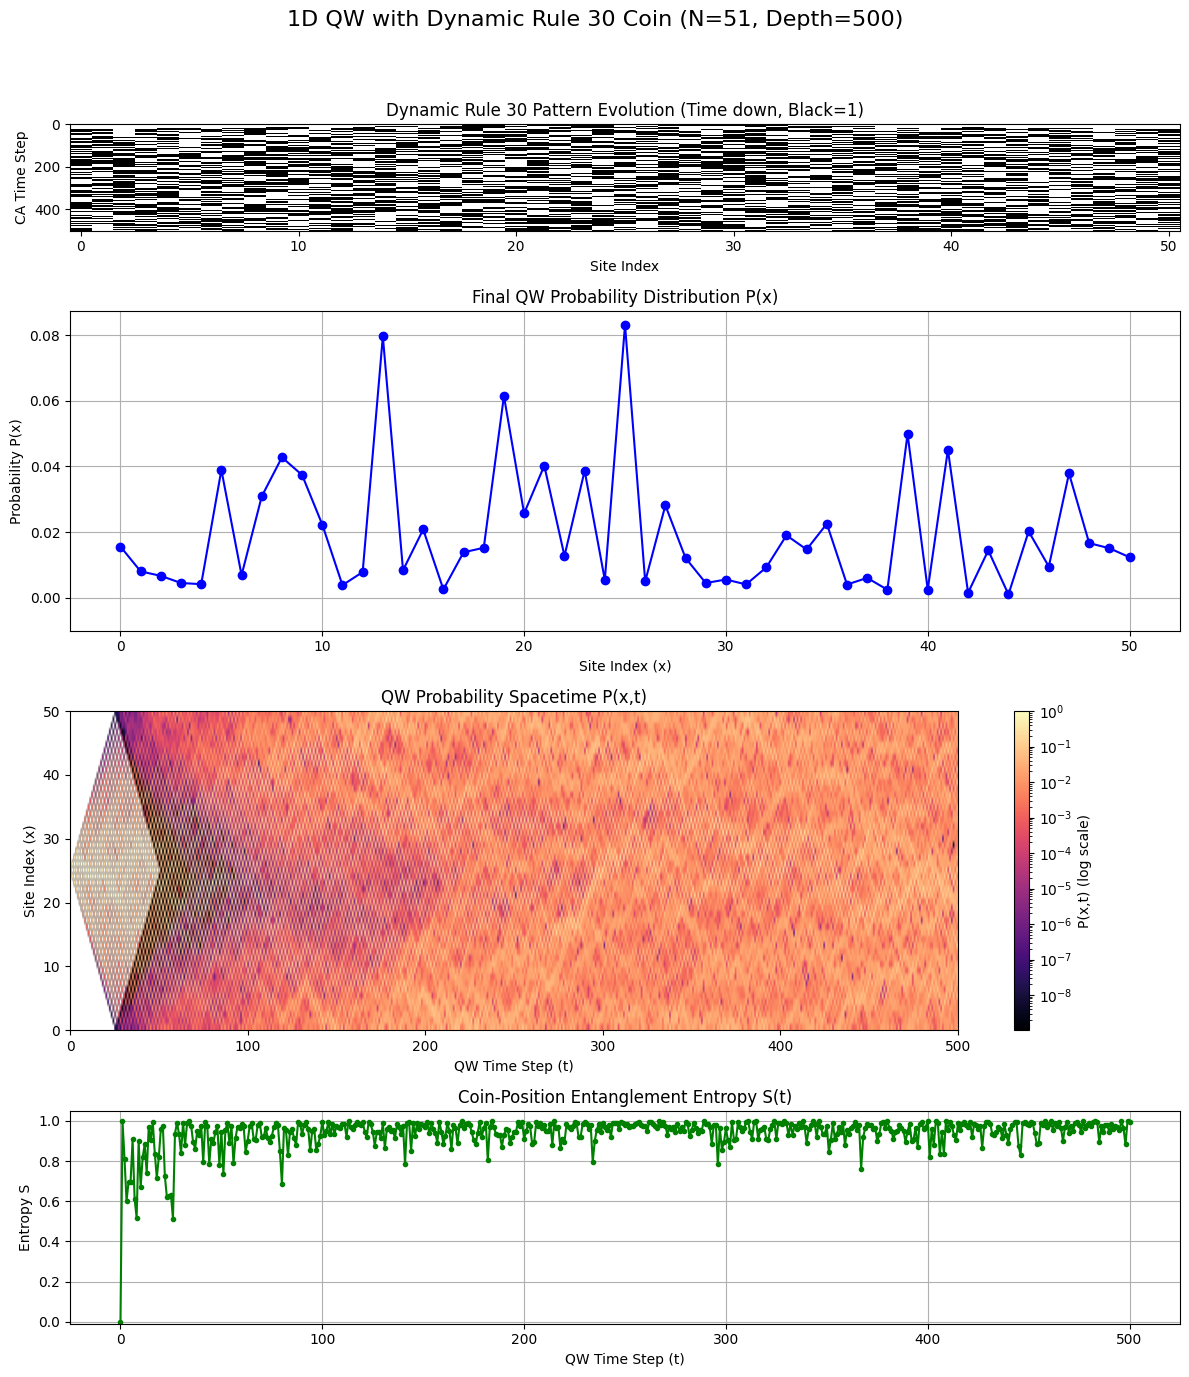


<<<<< END OF 1D QW DYNAMIC RULE 30 SIMULATION >>>>>


In [8]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import time

# --- Parameters ---
N_SITES_1D = 51
DEPTH_1D = 500
INITIAL_POS_1D = N_SITES_1D // 2
INITIAL_COIN_1D = 0
INITIAL_R30_CENTER_ONE = True # Start Rule 30 CA with a single '1' at the center

# --- Rule 30 Update Function ---
def update_rule30_line(current_line):
    width = len(current_line)
    new_line = np.zeros(width, dtype=int)
    for i in range(width):
        left = current_line[(i - 1 + width) % width]
        center = current_line[i]
        right = current_line[(i + 1) % width]

        pattern_val = (left << 2) | (center << 1) | right
        if pattern_val in [1, 2, 3, 4]: # Decimal for 001, 010, 011, 100
            new_line[i] = 1
        else:
            new_line[i] = 0
    return new_line

# --- Coin Matrices (1-Qubit Coin) ---
H_1Q = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]], dtype=np.complex128)
X_1Q = np.array([[0,1],[1,0]], dtype=np.complex128)
I_1Q = np.eye(2, dtype=np.complex128)

COIN_OP_R30_ZERO = H_1Q
COIN_OP_R30_ONE  = X_1Q @ H_1Q

# --- Helper Functions (1D QW) - (Same as before) ---
def get_1d_index(coin_val, site_pos, n_sites_1d):
    if not (0 <= site_pos < n_sites_1d and 0 <= coin_val <= 1):
        raise IndexError(f"Invalid coin ({coin_val}) or pos ({site_pos}) for 1D index (N_sites={n_sites_1d})")
    return coin_val + 2 * site_pos

def get_1d_coin_pos_from_index(k, n_sites_1d):
    state_dim_1d = 2 * n_sites_1d
    if not (0 <= k < state_dim_1d):
        raise IndexError(f"Invalid k ({k}) for 1D coin/pos (StateDim={state_dim_1d})")
    coin_val = k % 2
    site_pos = k // 2
    return coin_val, site_pos

# --- Initial State Preparation (1D QW) - (Same as before) ---
def prepare_initial_state_1d(n_sites_1d, initial_pos, initial_coin_val=0):
    state_dim_1d = 2 * n_sites_1d
    initial_state_vector = np.zeros(state_dim_1d, dtype=np.complex128)
    try:
        start_index = get_1d_index(initial_coin_val, initial_pos, n_sites_1d)
        initial_state_vector[start_index] = 1.0
        print(f"Initialized 1D walker at site {initial_pos} in coin state |{initial_coin_val}> (index {start_index})")
    except IndexError as e:
        print(f"Error during 1D initial state prep: {e}")
    return initial_state_vector

# --- Build QW Step Operator (dependent on current r30_pattern) ---
def build_1d_qw_step_operator(n_sites_1d, current_r30_pattern, coin0_op, coin1_op):
    """Builds the U_step = S @ C for the current r30_pattern."""
    state_dim_1d = 2 * n_sites_1d

    # Coin Operator C_full based on current_r30_pattern
    C_full = np.zeros((state_dim_1d, state_dim_1d), dtype=np.complex128)
    for site_idx in range(n_sites_1d):
        chosen_coin_op = coin0_op if current_r30_pattern[site_idx] == 0 else coin1_op
        idx_s_c0 = get_1d_index(0, site_idx, n_sites_1d)
        idx_s_c1 = get_1d_index(1, site_idx, n_sites_1d)
        C_full[idx_s_c0, idx_s_c0] = chosen_coin_op[0,0]
        C_full[idx_s_c1, idx_s_c0] = chosen_coin_op[1,0]
        C_full[idx_s_c0, idx_s_c1] = chosen_coin_op[0,1]
        C_full[idx_s_c1, idx_s_c1] = chosen_coin_op[1,1]

    # Shift Operator S_full (Periodic Boundaries)
    S_full = np.zeros((state_dim_1d, state_dim_1d), dtype=np.complex128)
    for k_in in range(state_dim_1d):
        coin_val, site_pos = get_1d_coin_pos_from_index(k_in, n_sites_1d)
        new_pos = site_pos
        if coin_val == 0:
            new_pos = (site_pos - 1 + n_sites_1d) % n_sites_1d
        else:
            new_pos = (site_pos + 1) % n_sites_1d
        k_out = get_1d_index(coin_val, new_pos, n_sites_1d)
        S_full[k_out, k_in] = 1.0

    U_step = S_full @ C_full
    return U_step

# --- Observables (1D QW) - (Same as before) ---
def calculate_p1_position_1d(state_vector, n_sites_1d):
    prob_dist_1d = np.zeros(n_sites_1d)
    for site_idx in range(n_sites_1d):
        idx_c0 = get_1d_index(0, site_idx, n_sites_1d)
        idx_c1 = get_1d_index(1, site_idx, n_sites_1d)
        prob_dist_1d[site_idx] = np.abs(state_vector[idx_c0])**2 + np.abs(state_vector[idx_c1])**2
    return prob_dist_1d

def calculate_coin_position_entanglement_1d(state_vector, n_sites_1d):
    coin_dim = 2
    state_dim_1d = coin_dim * n_sites_1d
    if len(state_vector) != state_dim_1d: return np.nan
    norm = np.linalg.norm(state_vector)
    if np.abs(norm - 1.0) > 1e-6:
        if norm < 1e-9: return 0.0
        state_vector = state_vector / norm
        if np.isnan(state_vector).any(): return np.nan
    try:
        rho_full_matrix = np.outer(state_vector, np.conjugate(state_vector))
        rho_coin = np.zeros((coin_dim, coin_dim), dtype=np.complex128)
        for site_idx in range(n_sites_1d):
            for c_row in range(coin_dim):
                 for c_col in range(coin_dim):
                      k_row = get_1d_index(c_row, site_idx, n_sites_1d)
                      k_col = get_1d_index(c_col, site_idx, n_sites_1d)
                      rho_coin[c_row, c_col] += rho_full_matrix[k_row, k_col]
        trace_rho_coin = np.trace(rho_coin)
        if np.abs(trace_rho_coin - 1.0) > 1e-6:
            if abs(trace_rho_coin) > 1e-9: rho_coin /= trace_rho_coin
        eigenvalues = np.linalg.eigvalsh(rho_coin)
        entropy = 0.0; epsilon = 1e-12
        for eig_val in eigenvalues:
            if eig_val > epsilon:
                try: entropy -= eig_val * np.log2(eig_val)
                except ValueError: pass
        return max(0.0, np.real(entropy))
    except Exception as e:
        print(f"Error calculating 1D coin-position entanglement: {e}")
        return np.nan

# --- Simulation Loop (1D QW with Dynamic Rule 30 Coin) ---
def run_1d_qw_dynamic_r30(
    n_sites_1d, depth, initial_pos, initial_coin_val,
    initial_r30_center_one, coin0_op, coin1_op
):
    # Initialize QW state
    current_qw_state = prepare_initial_state_1d(n_sites_1d, initial_pos, initial_coin_val)

    # Initialize Classical Rule 30 CA state
    current_r30_line = np.zeros(n_sites_1d, dtype=int)
    if initial_r30_center_one and n_sites_1d > 0:
        if n_sites_1d % 2 == 1: current_r30_line[n_sites_1d // 2] = 1
        else: current_r30_line[n_sites_1d // 2 -1] = 1

    prob_history_1d = [calculate_p1_position_1d(current_qw_state, n_sites_1d)]
    ent_history_1d = [calculate_coin_position_entanglement_1d(current_qw_state, n_sites_1d)]
    r30_history = [current_r30_line.copy()] # Store history of R30 patterns

    print(f"\nStarting 1D QW (Dynamic Rule 30 Coin) for {depth} steps...")
    start_time = time.time()
    for step in range(depth):
        # 1. Build QW step operator based on *current* R30 pattern
        U_step = build_1d_qw_step_operator(n_sites_1d, current_r30_line, coin0_op, coin1_op)

        # 2. Evolve QW state
        current_qw_state = U_step @ current_qw_state
        norm = np.linalg.norm(current_qw_state)
        if abs(norm) > 1e-9 : current_qw_state /= norm
        else: print(f"Warning: QW State norm zero at step {step+1}"); break

        # 3. Evolve Classical Rule 30 CA pattern for the *next* QW step
        current_r30_line = update_rule30_line(current_r30_line)

        # Store observables and patterns
        prob_history_1d.append(calculate_p1_position_1d(current_qw_state, n_sites_1d))
        ent_history_1d.append(calculate_coin_position_entanglement_1d(current_qw_state, n_sites_1d))
        r30_history.append(current_r30_line.copy())

        if (step + 1) % 10 == 0:
            print(f"  Completed step {step + 1}/{depth}")
    end_time = time.time()
    print(f"Evolution complete. Time: {end_time - start_time:.2f} seconds.")

    return {
        "prob_history": np.array(prob_history_1d),
        "ent_history": np.array(ent_history_1d),
        "r30_history": np.array(r30_history), # Store all R30 patterns
        "params": {
            "n_sites": n_sites_1d, "depth": depth,
            "initial_pos": initial_pos, "initial_coin": initial_coin_val,
            "initial_r30_center_one": initial_r30_center_one
        }
    }

# --- Plotting and Summary (1D QW with Dynamic Rule 30) ---
def plot_1d_qw_results_dynamic_r30(results):
    params = results["params"]; prob_hist = results["prob_history"]
    ent_hist = results["ent_history"]; r30_hist = results["r30_history"]

    depth = params['depth']

    fig, axs = plt.subplots(4, 1, figsize=(12, 14), gridspec_kw={'height_ratios': [1, 3, 3, 2]})
    fig.suptitle(f"1D QW with Dynamic Rule 30 Coin (N={params['n_sites']}, Depth={depth})", fontsize=16)

    # Plot Rule 30 pattern evolution (spacetime diagram)
    axs[0].imshow(r30_hist, cmap='binary', aspect='auto', interpolation='nearest')
    axs[0].set_title("Dynamic Rule 30 Pattern Evolution (Time down, Black=1)")
    axs[0].set_xlabel("Site Index"); axs[0].set_ylabel("CA Time Step")

    # Plot final QW probability distribution
    axs[1].plot(np.arange(params['n_sites']), prob_hist[-1, :], marker='o', linestyle='-', color='blue')
    axs[1].set_title("Final QW Probability Distribution P(x)")
    axs[1].set_xlabel("Site Index (x)"); axs[1].set_ylabel("Probability P(x)")
    axs[1].grid(True); axs[1].set_ylim(bottom=-0.01)

    # Plot QW probability spacetime diagram (P(x,t))
    # Transpose prob_hist so time is on y-axis, position on x-axis
    prob_spacetime = prob_hist.T
    # Use LogNorm for better visibility if there are large variations
    pos_probs = prob_spacetime[prob_spacetime > 1e-9]
    min_val = pos_probs.min() if len(pos_probs) > 0 else 1e-9
    max_val = prob_spacetime.max()
    norm = colors.LogNorm(vmin=min_val, vmax=max(max_val, min_val + 1e-6))
    im = axs[2].imshow(prob_spacetime, aspect='auto', origin='lower', cmap='magma', norm=norm,
                       extent=[0, depth, 0, params['n_sites']-1]) # Correct extent
    plt.colorbar(im, ax=axs[2], label="P(x,t) (log scale)")
    axs[2].set_title("QW Probability Spacetime P(x,t)")
    axs[2].set_xlabel("QW Time Step (t)"); axs[2].set_ylabel("Site Index (x)")


    # Plot entanglement history
    time_steps_qw = np.arange(depth + 1) # QW has depth+1 data points including t=0
    axs[3].plot(time_steps_qw, ent_hist, marker='.', linestyle='-', color='green')
    axs[3].set_title("Coin-Position Entanglement Entropy S(t)")
    axs[3].set_xlabel("QW Time Step (t)"); axs[3].set_ylabel("Entropy S")
    axs[3].grid(True); axs[3].set_ylim(bottom=-0.01, top=1.05)

    plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

def generate_1d_qw_text_output_dynamic_r30(results):
    params = results["params"]; prob_hist = results["prob_history"]; ent_hist = results["ent_history"]
    output_lines = ["\n--- 1D QW (Dynamic Rule 30 Coin) Summary ---"]
    output_lines.append(f"N_sites={params['n_sites']}, Depth={params['depth']}, StartPos={params['initial_pos']}, StartCoin={params['initial_coin']}")

    output_lines.append("\nTop 5 Final Probabilities (Site: Prob):")
    final_probs = prob_hist[-1, :]
    sorted_indices = np.argsort(final_probs)[::-1]
    for i in range(min(5, params['n_sites'])):
        idx = sorted_indices[i]
        output_lines.append(f"  Site {idx}: {final_probs[idx]:.5f}")

    output_lines.append("\nCoin-Position Entanglement vs. Time:")
    num_steps_total = len(ent_hist)
    indices_to_show = [0]
    if num_steps_total > 2: indices_to_show.append(num_steps_total // 2)
    if num_steps_total > 1: indices_to_show.append(num_steps_total - 1)
    indices_to_show = sorted(list(set(indices_to_show)))
    for idx in indices_to_show:
        s_val_str = f"{ent_hist[idx]:.6f}" if np.isfinite(ent_hist[idx]) else "nan"
        output_lines.append(f"  Step {idx}: S = {s_val_str}")
    output_lines.append("--- End of Summary ---")
    return "\n".join(output_lines)


# --- Main Execution (1D QW) ---
if __name__ == "__main__":
    print("Starting 1D Quantum Walk with DYNAMIC Rule 30 dependent coin...")

    results_1d_dynamic_r30 = run_1d_qw_dynamic_r30(
        n_sites_1d=N_SITES_1D,
        depth=DEPTH_1D,
        initial_pos=INITIAL_POS_1D,
        initial_coin_val=INITIAL_COIN_1D,
        initial_r30_center_one=INITIAL_R30_CENTER_ONE,
        coin0_op=COIN_OP_R30_ZERO,
        coin1_op=COIN_OP_R30_ONE
    )

    text_summary = generate_1d_qw_text_output_dynamic_r30(results_1d_dynamic_r30)
    print(text_summary)

    plot_1d_qw_results_dynamic_r30(results_1d_dynamic_r30)

    print("\n<<<<< END OF 1D QW DYNAMIC RULE 30 SIMULATION >>>>>")

Complex Emergent Dynamics: The interaction of a simple quantum walker with a co-evolving classical, chaotic rule (Rule 30) generates highly complex and non-trivial probability distributions.
Environment Shapes Quantum Trajectories: The Rule 30 pattern clearly acts as a dynamic "medium" that sculpts the flow of quantum probability.
Rapid and Sustained Entanglement: The coin-position entanglement quickly reaches near-maximal values and stays there, highlighting the profound quantum correlations generated by the rule-based interactions. This is a key feature distinguishing it from a purely classical system.
"Computational" Universe Toy Model: This simulation is a more sophisticated toy model of a computational universe where:
The "spacetime" (Rule 30 CA) has its own dynamics.
A "particle" (the quantum walker) moves through this spacetime.
The particle's local "physics" (coin operation) is determined by the state of the spacetime at its location.
The particle's quantum nature (superposition, interference, entanglement) leads to rich emergent behavior.